---

#Analysis of Coffee Blend Ratings
---

By [James Craven](https://github.com/4jamesccraven), [Savion Jackson](https://github.com/SavJackson), & [Matthew Lindsey](https://github.com/MatthewLindsey75) \\
12/7/2023

*Data set is taken from* [Coffee Reviews Dataset @ Kaggle.com](https://www.kaggle.com/datasets/schmoyote/coffee-reviews-dataset)

Note that this was done over the course of a semester across multiple separate notebooks, as such much of the 'steps' in this particular notebook are representative of past work completed elsewhere

In [ ]:
#drive
from google.colab import drive
#utilities
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
#machine learning
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
import sklearn.metrics as mtrcs

In [ ]:
drive.mount('/content/drive', force_remount=True)
#Change as needed:
dir = '/content/drive/MyDrive/DSCI-201-Materials/Final/datasets/'

Mounted at /content/drive


**Overview**
---

This dataset was chosen to create a machine learning model that could accurately provide a prediction of the rating of coffee. We opted to remove a few descriptive features to simplify the formulation of the machine learning model as well as remove unnecessary redundancies among the descriptive features. Those descriptive features included: Location_Country, Review_Date, and Description. Although, initially, they did not provide any relevant gain of information to the rating of the coffee, they additionally required more effort to extrapolate unique and undesirable inputs. Upon further introspection and data pruning some of these changes were reverted, namely the exclusion of Location_Country.

**Data Preparation**
--

In [ ]:
pre_cleaning_data = pd.read_csv(dir + 'original_data_set.csv')
pre_cleaning_data.head()

,ROASTER,ROAST,LOC_COUNTRY,ORIGIN,100G_USD,RATING
0,Revel Coffee,Medium-Light,United States,Ethiopia,4.70,92
1,Roast House,Medium-Light,United States,Ethiopia,4.19,92
2,Big Creek Coffee Roasters,Medium,United States,Ethiopia,4.85,94
3,Red Rooster Coffee Roaster,Light,United States,Ethiopia,5.14,93
4,Willoughby's Coffee & Tea,Medium-Light,United States,Ethiopia,3.97,93


The original data set was largely clean that it was from Kaggle; the only issue was that it was missing some values for the 'ROAST' feature. Given the relatively low quantity of missing data and the fact that it was categorical, we went with mode imputation.

In [ ]:
pre_cleaning_data.describe(include='all')

,ROASTER,ROAST,LOC_COUNTRY,ORIGIN,100G_USD,RATING
count,1246,1234,1246,1246,1246.000000,1246.000000
unique,300,5,12,27,NaN,NaN
top,Kakalove Cafe,Medium-Light,United States,Ethiopia,NaN,NaN
freq,91,904,774,447,NaN,NaN
mean,NaN,NaN,NaN,NaN,10.479125,93.306581
std,NaN,NaN,NaN,NaN,13.486674,1.479413
min,NaN,NaN,NaN,NaN,0.170000,84.000000
25%,NaN,NaN,NaN,NaN,5.260000,93.000000
50%,NaN,NaN,NaN,NaN,6.170000,93.000000
75%,NaN,NaN,NaN,NaN,9.600000,94.000000


As seen above, the mode for roast is Medium-Light, so all missing data was imputated with that level.

Additionally, the target level had a seemingly randomly defined range, which we feared would affect ML output poorly, so we normalised it. The result of this cleaning was this dataset:

In [ ]:
dataset = pd.read_csv(dir + 'prepared_data.csv')
dataset.head()

,ROASTER,ROAST,LOC_COUNTRY,ORIGIN,100G_USD,RATING
0,Revel Coffee,Medium-Light,United States,Ethiopia,4.70,0.615385
1,Roast House,Medium-Light,United States,Ethiopia,4.19,0.615385
2,Big Creek Coffee Roasters,Medium,United States,Ethiopia,4.85,0.769231
3,Red Rooster Coffee Roaster,Light,United States,Ethiopia,5.14,0.692308
4,Willoughby's Coffee & Tea,Medium-Light,United States,Ethiopia,3.97,0.692308


In [ ]:
dataset.isna().sum()

ROASTER        0
ROAST          0
LOC_COUNTRY    0
ORIGIN         0
100G_USD       0
RATING         0
dtype: int64

**Data Exploration**
--

Upon exploring the data, we found that not many of the features had high correlation, but there was somewhat of a correlation between price and rating. While low prices didn't have much of an impact on the rating, a high price seemed highly correlated with a high rating. The type of roast doesn't really seem to make a large difference, either.

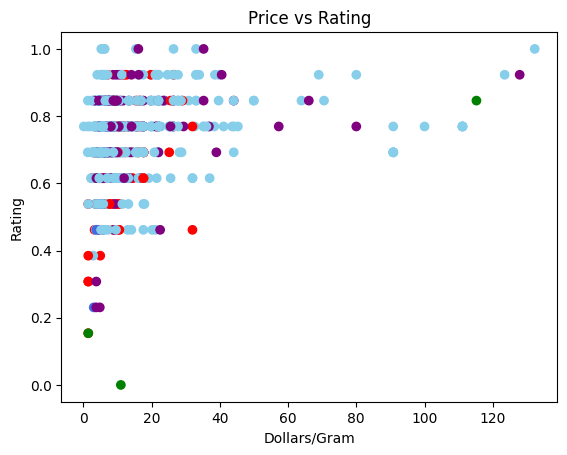

In [ ]:
colors = {'Dark':'#4169E1', 'Medium-Dark':'#008000', 'Medium':'#FF0000','Medium-Light':'#87CEEB','Light':'#800080'}
plt.scatter(dataset['100G_USD'], dataset['RATING'], c = dataset['ROAST'].map(colors))
ax = plt.gca()
plt.title("Price vs Rating")
plt.xlabel("Dollars/Gram")
plt.ylabel("Rating")
plt.show()

We can also see that there is a high peak for the in the distribution, showing that most of the ratings are fairly positive (ratings around $\frac{7}{10}$)

<Axes: xlabel='RATING', ylabel='Count'>

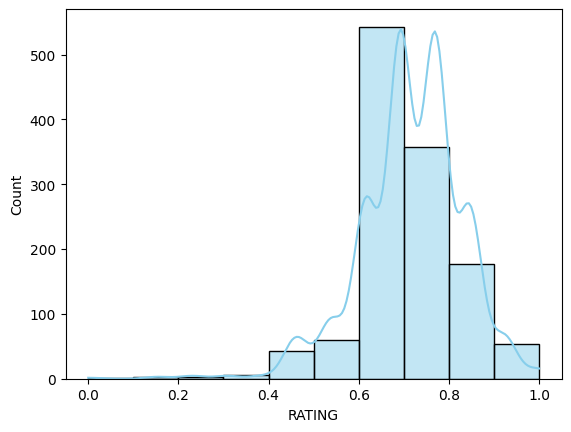

In [ ]:
sns.histplot(dataset['RATING'], kde=True, color='skyblue', bins=10)

{'whiskers': [<matplotlib.lines.Line2D at 0x78fa8bf5a800>,
 'caps': [<matplotlib.lines.Line2D at 0x78fa8bf88310>,
 'boxes': [<matplotlib.lines.Line2D at 0x78fa8bf58100>],
 'medians': [<matplotlib.lines.Line2D at 0x78fa8bf88850>],
 'fliers': [],
 'means': []}

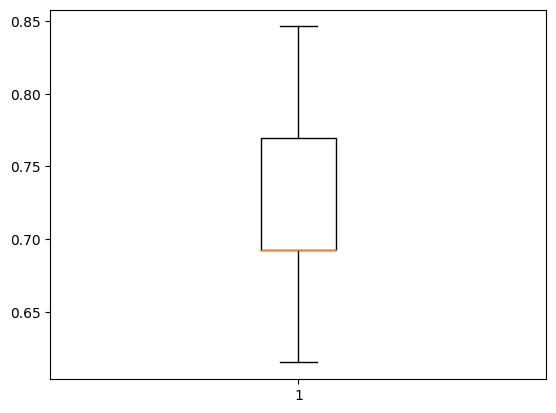

In [ ]:
plt.boxplot(dataset['RATING'], showfliers=False)

**Further visualisations were done on our Tableau dashboard that can be found [here](https://public.tableau.com/views/CoffeeReviewsDataViz/CoffeeReviews?:language=en-US&:display_count=n&:origin=viz_share_link).**

**Model Training**
--

We reserve 30% of the data for testing, then train the models. We have chosen decision trees as they are a common choice and tend to be a good start, and regression because the target data is continuous.

Note: the data was encoded in various projects using `sklearn.preprocessing.labelEncoder`

In [ ]:
encoded_data = pd.read_csv(dir + 'prepared_data_encoded.csv')
x = encoded_data.drop(columns=['RATING'])
y = encoded_data['RATING']

In [ ]:
training_data, evaluation_data, training_targets, evaluation_targets = train_test_split(x, y, test_size=0.3)

In [ ]:
decision_tree_model = DecisionTreeClassifier(criterion= 'gini', max_depth= 6) #tested this multiple times, gini with 6 was the best result, disappointingly
regression_model = LinearRegression()

In [ ]:
decision_tree_model.fit(training_data, training_targets)

DecisionTreeClassifier(max_depth=6)

In [ ]:
regression_model.fit(training_data, training_targets)

LinearRegression()

**Model Evaluations**
--

Evaluation of the tree model:

In [ ]:
predicted_targets = decision_tree_model.predict(evaluation_data)

In [ ]:
print(f"{'Accuracy:':<17}| {mtrcs.accuracy_score(evaluation_targets, predicted_targets)}")
print(f"{'Precsion:':<17}| {mtrcs.precision_score(evaluation_targets, predicted_targets, average='micro')}")
print(f"{'Recall:':<17}| {mtrcs.recall_score(evaluation_targets, predicted_targets, average='micro')}")
print(f"{'Confusion Matrix:':<17}\n {mtrcs.confusion_matrix(evaluation_targets, predicted_targets)}")

Accuracy:        | 0.2887700534759358
Precsion:        | 0.2887700534759358
Recall:          | 0.2887700534759358
Confusion Matrix:
 [[ 0  0  0  0  0  0  0  1  0  0  0  0]
 [ 0  0  0  0  1  0  0  0  0  0  0  0]
 [ 0  1  0  0  0  0  0  1  0  0  0  0]
 [ 0  0  0  0  0  0  0  1  0  0  0  0]
 [ 0  0  0  0  0  0  2  7  4  0  0  0]
 [ 0  0  0  0  0  0  4 15  6  0  0  0]
 [ 0  0  0  0  1  0  7 29 14  2  0  0]
 [ 0  0  0  0  0  0  9 59 39  2  0  0]
 [ 0  0  0  0  0  0  9 42 35 12  0  0]
 [ 0  0  0  0  0  0  4 19 19  7  1  1]
 [ 0  0  0  0  1  0  0  4  4  8  0  0]
 [ 0  0  0  0  0  0  0  0  2  1  0  0]]


Evaluation of the regression model:

In [ ]:
predicted_targets2 = regression_model.predict(evaluation_data)

In [ ]:
print(f"{'Mean Absolute Error:':<21}| {mtrcs.mean_absolute_error(evaluation_targets, predicted_targets2)}")
print(f"{'R Squared Result:':<21}| {mtrcs.r2_score(evaluation_targets, predicted_targets2)}")

Mean Absolute Error: | 1.0994000789538954
R Squared Result:    | 0.13961432905255478


We would not recommend deploying either of these models, as they failed evaluation metrics spectacularly. It is likely that we are lacking data. The bean is but a microcosm of what decides on the subjective result of whether or not a person likes it. There could be more factors that need considering such flavour profiles (e.g., strength, aroma, etc.) It is also possible that other models may yield better results, but that is out of the scope of this introductory experience.